In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import numpy as np 
from matplotlib import pyplot as plt
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import random_split
from torchvision import models,datasets
import os
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image
from torch.optim import lr_scheduler

In [2]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    print('using device: cuda')
else:
    print('using device: cpu')

device = torch.device("cuda:0" if USE_GPU else "cpu")

using device: cuda


In [3]:
train_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [4]:
parent_dir = '../input/bee-vs-wasp/kaggle_bee_vs_wasp'
print(os.listdir(parent_dir))

['wasp2', 'other_noinsect', 'other_insect', 'example_notebook', 'README.md', 'bee1', 'wasp1', 'label_generator', 'bee2', 'labels.csv']


In [5]:
#Create a list of bee files
bee1 = '../input/bee-vs-wasp/kaggle_bee_vs_wasp/bee1'
bee2 = '../input/bee-vs-wasp/kaggle_bee_vs_wasp/bee2'
bee_list = os.listdir(bee1)
print(len(bee_list))
for i in os.listdir(bee2):
    bee_list.append(i)
print(bee1.split('/')[-1])

#Create a list of wasp files
wasp1 = '../input/bee-vs-wasp/kaggle_bee_vs_wasp/wasp1'
wasp2 = '../input/bee-vs-wasp/kaggle_bee_vs_wasp/wasp2'
wasp_list = os.listdir(wasp1)
print(len(wasp_list))
for i in os.listdir(wasp2):
    wasp_list.append(i)
print(len(wasp_list))

oi = '../input/bee-vs-wasp/kaggle_bee_vs_wasp/other_insect'
oi_list = os.listdir(oi)
print(len(oi_list))

oni = '../input/bee-vs-wasp/kaggle_bee_vs_wasp/other_noinsect'
oni_list = os.listdir(oni)
print(len(oni_list))

2469
bee1
2127
4943
2439
856


In [6]:
class BeeWaspDataset(Dataset):
    def __init__(self, filelist,directory,transform = None):
        self.filelist = filelist
        self.directory = directory
        self.transform = transform
    def __len__(self):
        return len(self.filelist)
    
    def __getitem__(self,idx):
        img =  Image.open(os.path.join(self.directory, self.filelist[idx]))
        img = img.convert('RGB')
        img = self.transform(img)
        
        if 'bee1' in self.directory.split('/')[-1]:
            self.label = 0
        elif 'bee2' in self.directory.split('/')[-1]:
            self.label = 0
        elif 'wasp1' in self.directory.split('/')[-1]:
            self.label = 1
        elif 'wasp2' in self.directory.split('/')[-1]:
            self.label = 1
        elif 'other_insect' in self.directory.split('/')[-1]:
            self.label = 2
        elif 'other_noinsect' in self.directory.split('/')[-1]:
            self.label = 3
        
        img = img.numpy()
        return img.astype('float32'), self.label   
    
    

In [7]:
classes = ['bee1','bee2','wasp1','wasp2','other_insect','other_noinsect']
working_ds = None
for c in classes:
    directory = os.path.join(parent_dir,c)
    file_list = os.listdir(directory)
    new = BeeWaspDataset(file_list,directory,train_transform)
    
    if working_ds == None:
        working_ds = new
    else:
        working_ds = ConcatDataset([working_ds,new])
print(len(working_ds))

11421


In [8]:
def train_val_split(working_ds):
    val_split = 0.05
    l = float(len(working_ds))
    m = int(val_split*l)
    train_ds,val_ds = random_split(working_ds,[int(l)-m,m])
    return train_ds,val_ds

In [9]:
train_ds,val_ds = train_val_split(working_ds)

In [10]:
train_loader = torch.utils.data.DataLoader(dataset=train_ds,
                                           batch_size=32, 
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_ds,
                                          batch_size=32, 
                                          shuffle=False)

In [11]:
for i,l in train_loader:
    c = 0
    c= c+1
    print(l)
    if c == 1:
        break

tensor([0, 0, 1, 1, 2, 0, 1, 0, 2, 0, 0, 1, 0, 0, 1, 2, 1, 3, 0, 1, 0, 2, 2, 0,
        2, 0, 0, 2, 1, 0, 1, 2])


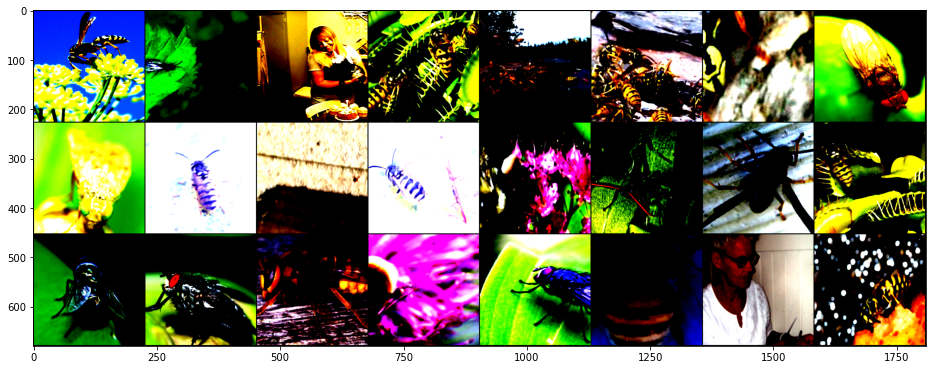

In [12]:
import matplotlib.pyplot as plt
import numpy
samples, labels = iter(train_loader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(numpy.transpose(np_grid_imgs, (1,2,0)))

In [13]:

def model_eval(dataloader,model):
    total = 0
    correct = 0
    for data in dataloader:
      images, l = data
      
      images = images.to(device)
      l = l.to(device)
      
      out = model(images)
      max_val, preds = torch.max(out,dim=1)
      
      total += l.shape[0]                   
      correct += (preds == l).sum().item()  
      accuracy = (100 * correct)/total
    
    
    return accuracy

In [14]:
def train(model, criterion, optimizer,sch,num_epochs):
  for epoch in range(num_epochs): 
      print("Epoch:",epoch+1)
      running_loss = 0.0
      history =[]
      for i,data in enumerate(train_loader,0):
          inputs,labels = data
    
          inputs = inputs.to(device)
          labels = labels.to(device)

          optimizer.zero_grad()
    
          output = model(inputs)
          output = output.to(device)
          loss = criterion(output, labels)
          
          loss.backward()
          optimizer.step()
          
          
          running_loss += loss.item()
    
          
          if i % 100 == 99:    
              print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 100))
              
              running_loss = 0.0
      
      sch.step()  
      print('Epoch:', epoch+1,'LR:', sch.get_last_lr())
      print("EPOCH OVER")
      train_acc = model_eval(train_loader,model)
      with torch.no_grad():
        test_acc = model_eval(val_loader,model)
      print("############################")
      print("Training Accuracy:",train_acc,"Testing Accuracy",test_acc)
      print("############################")
      print("")
  return model
    

In [15]:

fe = models.resnet18(pretrained=True)
for param in fe.parameters():
	param.requires_grad = True
num_ftrs = fe.fc.in_features
class ResNet18(nn.Module):
  def __init__(self):
    super(ResNet18, self).__init__()
    self.features = torch.nn.Sequential(*list(fe.children())[:-1])
    
    self.drop1 = nn.Dropout(0.3)
    self.fc1 = nn.Linear(num_ftrs,128)
    self.drop2 = nn.Dropout(0.2)
    self.fc2 = nn.Linear(128,4)
    #We did not add a softmax layer here because the CrossEntropy Loss function contains a softmax, so if you want 
    #to test output, you will have to add a softmax block in addition to the model block
    
  def forward(self,x):
    x = self.features(x)
    
    x = x.view(x.shape[0],512)
    
    x = self.drop1(x)
    x = F.relu(self.fc1(x))
    x = self.drop2(x)
    x = F.relu(self.fc2(x))
    
    
    
    return x


criterion = nn.CrossEntropyLoss()    

resnet_model = ResNet18()
resnet_model = resnet_model.to(device)


print(resnet_model)

ResNet18(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [16]:
optimizer = optim.SGD(resnet_model.parameters(), lr=1e-3, momentum=0.95)
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

resnet_model = train(resnet_model,criterion,optimizer,scheduler,num_epochs = 15)

Epoch: 1
[1,   100] loss: 0.966
[1,   200] loss: 0.460
[1,   300] loss: 0.333
Epoch: 1 LR: [0.001]
EPOCH OVER
############################
Training Accuracy: 90.24884792626727 Testing Accuracy 88.09106830122592
############################

Epoch: 2
[2,   100] loss: 0.306
[2,   200] loss: 0.276
[2,   300] loss: 0.274
Epoch: 2 LR: [0.001]
EPOCH OVER
############################
Training Accuracy: 91.2258064516129 Testing Accuracy 90.19264448336253
############################

Epoch: 3
[3,   100] loss: 0.249
[3,   200] loss: 0.238
[3,   300] loss: 0.253
Epoch: 3 LR: [0.001]
EPOCH OVER
############################
Training Accuracy: 91.91705069124424 Testing Accuracy 89.84238178633976
############################

Epoch: 4
[4,   100] loss: 0.232
[4,   200] loss: 0.209
[4,   300] loss: 0.233
Epoch: 4 LR: [0.001]
EPOCH OVER
############################
Training Accuracy: 93.02304147465438 Testing Accuracy 90.19264448336253
############################

Epoch: 5
[5,   100] loss: 0.236
[5,  